This script creates testing data from NSIDC in the same format as Google Earth Engine Data in order to ensure that when IceValidation is run, on this test dataset, the resulting error is 0.

In [35]:
import earthaccess
import xarray as xr
import dask
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import glob
import re
import random
import matplotlib.pyplot as plt

# colormap for plotting sea ice throughout rest of project

cmap = plt.get_cmap("Blues_r").copy()
cmap.set_bad(color='lightgray')

# authenticate NASA earth access

auth = earthaccess.login(strategy='interactive', persist = True)

In [36]:
# search NASA database for Team

results = earthaccess.search_data(
    short_name= 'NSIDC-0051',
    temporal=('2023-01-01', '2023-12-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

import re
filtered_results = [
    g for g in results
    if re.search(r'_20\d{6}_', g.data_links(access='external')[0])
]

random_results = random.sample(filtered_results, 40)

print(f"We found {len(results)} results matching your parameters, and filtered them down to {len(filtered_results)} by removing monthly averages")
print(f'we then selected {len(random_results)} random results')

We found 359 results matching your parameters, and filtered them down to 347 by removing monthly averages
we then selected 40 random results


In [37]:
# get files from NSIDC

files_team = earthaccess.open(random_results)

# stream team into xarray

ds = xr.open_mfdataset(files_team, parallel = True, concat_dim="time", combine="nested", data_vars='minimal', coords='minimal', compat='override')

QUEUEING TASKS | :   0%|          | 0/40 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/40 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/40 [00:00<?, ?it/s]

In [38]:
# sample this dataset

nrows = ds.sizes['y']
ncols = ds.sizes['x']

# assign row and col as indexes

ds_indexed = ds.assign_coords({
    'row': ('y', np.arange(nrows)),
    'col': ('x', np.arange(ncols))
}).swap_dims({'y': 'row', 'x': 'col'})

# convert to dataframe

df = ds_indexed.to_dataframe().reset_index()
df['Row'] = df['row'] + 1
df['Column'] = df['col'] + 1
df['SI frac'] = df['F17_ICECON']
df['Date'] = df['time']
df = df.drop(columns=['time', 'row', 'col', 'F17_ICECON', 'crs', 'x', 'y'])

# sample random rows

sampled_data = df.sample(n=400, random_state=42)
sampled_data.to_csv('../data/testing/test_data.csv')
df

,Row,Column,SI frac,Date
0,1,1,0.0,2023-05-01
1,1,2,0.0,2023-05-01
2,1,3,0.0,2023-05-01
3,1,4,0.0,2023-05-01
4,1,5,0.0,2023-05-01
...,...,...,...,...
5447675,448,300,0.0,2023-06-05
5447676,448,301,0.0,2023-06-05
5447677,448,302,0.0,2023-06-05
5447678,448,303,0.0,2023-06-05


This script accesses PMW data from NSIDC for 2023 and pairs that with the testing data from 2023 created above. The testing data is organized such that the errror should be 0.

In [39]:
# import libraries

import earthaccess
import xarray as xr
import dask
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio import features
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj, Transformer
from pathlib import Path
import glob
import fnmatch

# colormap for plotting sea ice throughout rest of project

cmap = plt.get_cmap("Blues_r").copy()
cmap.set_bad(color='lightgray')

# authenticate NASA earth access

auth = earthaccess.login(strategy='interactive', persist = True)

We found 359 results matching your parameters, and filtered them down to 347 by removing monthly averages


QUEUEING TASKS | :   0%|          | 0/347 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/347 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/347 [00:00<?, ?it/s]

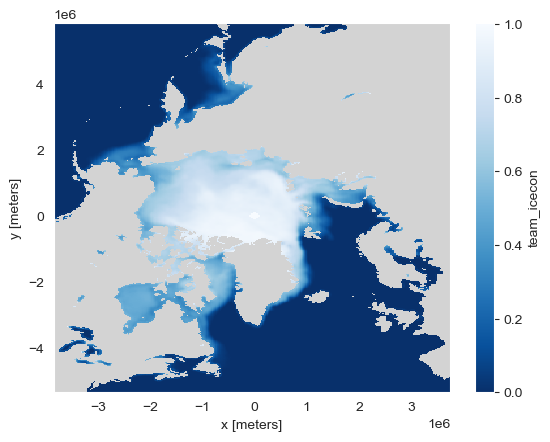

In [40]:
# search NASA database for Team

results = earthaccess.search_data(
    short_name= 'NSIDC-0051',
    temporal=('2023-01-01', '2023-12-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

import re
filtered_results = [
    g for g in results
    if re.search(r'_20\d{6}_', g.data_links(access='external')[0])
]

print(f"We found {len(results)} results matching your parameters, and filtered them down to {len(filtered_results)} by removing monthly averages")

# get files from NSIDC

files_team = earthaccess.open(filtered_results)

# stream team into xarray

ds = xr.open_mfdataset(files_team, parallel = True, concat_dim="time", combine="nested", data_vars='minimal', coords='minimal', compat='override')

# change ice concentration variable to something universal

icecon_vars = sorted([var for var in ds.data_vars if 'ICECON'in var], reverse=True)
icecon = ds[icecon_vars].to_array("source").max("source", skipna=True)

# add back to dataset and clean up
ds = ds.assign(team_icecon=icecon).drop_vars(icecon_vars)

# print dataset and plot just to check this works

ds.team_icecon.where(ds.team_icecon < 1.01).mean(dim='time').plot(cmap=cmap)

In [41]:
# read in land file from geopandas and initialize transform (from NSIDC metadata)
print('Calculating distance from land for each pixel')

land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
land = land.to_crs(epsg=3411)
transform = [25000, 0, -3830000, 0, -25000, 5830000]

# use transform to mask out coastal cells

land_mask = features.rasterize(
    ((geom, 1) for geom in land.geometry),
    out_shape=(448, 304),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# calculate distance from land using euclidian distance transform

distance_from_land = distance_transform_edt(land_mask == 0)

# convert to xarray.DataArray

distance_xr = xr.DataArray(
    distance_from_land,
    coords={'y': ds.y, 'x': ds.x},
    dims=('y', 'x'),
    name='distance_to_land_cells'
)

# add as data variable in ds

ds['edtl'] = distance_xr

Calculating distance from land for each pixel


In [56]:
# data cleaning of visual datasets

visual = pd.read_csv('../data/testing/test_data.csv')

# convert things for xarray

visual["time"] = pd.to_datetime(visual["Date"], yearfirst=True)
visual['row'] = visual['Row'] - 1
visual['col'] = visual['Column'] - 1

# drop duplicates

visual = visual.drop_duplicates(subset=["time", "row", "col"])
visual

,Unnamed: 0,Row,Column,SI frac,Date,time,row,col
0,4783102,54,271,1.016,2023-01-29,2023-01-29,53,270
1,339247,220,288,1.016,2023-01-01,2023-01-01,219,287
2,1461598,328,271,0.000,2023-07-23,2023-07-23,327,270
3,2169311,416,272,0.000,2023-10-22,2023-10-22,415,271
4,4136193,166,274,1.016,2023-01-14,2023-01-14,165,273
...,...,...,...,...,...,...,...,...
395,3035657,130,218,1.016,2023-10-21,2023-10-21,129,217
396,1770063,447,176,0.000,2023-06-03,2023-06-03,446,175
397,489225,266,90,0.000,2023-09-23,2023-09-23,265,89
398,789769,358,282,0.000,2023-08-13,2023-08-13,357,281


In [43]:
# reindex data array

nrows = ds.sizes['y']
ncols = ds.sizes['x']

ds = ds.assign_coords({
    'row': ('y', np.arange(nrows)),
    'col': ('x', np.arange(ncols))
}).swap_dims({'y': 'row', 'x': 'col'})

In [ ]:
# convert to xarray

da_sparse = visual.set_index(['time', 'row', 'col']).to_xarray()
da_full = da_sparse.reindex_like(ds, method=None)

da_full = da_full.chunk({'time': 2})
ds = ds.assign(**{'visual_ice': da_full['SI frac']})
ds = ds.assign(**{'visual_ice': da_full['SI frac']})

In [55]:
da_sparse

<xarray.Dataset> Size: 85MB
Dimensions:     (time: 40, row: 252, col: 211)
Coordinates:
  * time        (time) datetime64[ns] 320B 2023-01-01 2023-01-13 ... 2023-12-13
  * row         (row) int64 2kB 0 4 5 8 12 13 15 ... 439 440 441 443 445 446 447
  * col         (col) int64 2kB 1 2 4 7 9 11 12 ... 295 296 297 298 299 300 302
Data variables:
    Unnamed: 0  (time, row, col) float64 17MB nan nan nan nan ... nan nan nan
    Row         (time, row, col) float64 17MB nan nan nan nan ... nan nan nan
    Column      (time, row, col) float64 17MB nan nan nan nan ... nan nan nan
    SI frac     (time, row, col) float64 17MB nan nan nan nan ... nan nan nan
    Date        (time, row, col) object 17MB nan nan nan nan ... nan nan nan nan

<Figure size 640x480 with 0 Axes>

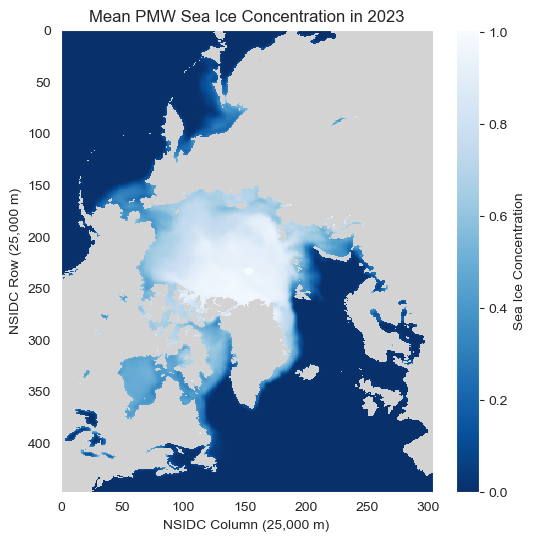

In [51]:
# sanity check one

sns.set_style('darkgrid')
sns.despine()

ds_subset = ds.where(ds.team_icecon < 1.01)
ax = ds_subset.team_icecon.mean(dim='time').plot(
    cmap=cmap,
    cbar_kwargs={'label': 'Sea Ice Concentration'},
    figsize=(6,6)
)

plt.title("Mean PMW Sea Ice Concentration in 2023")
plt.xlabel("NSIDC Column (25,000 m)")
plt.ylabel("NSIDC Row (25,000 m)")
plt.gca().invert_yaxis()
plt.show()

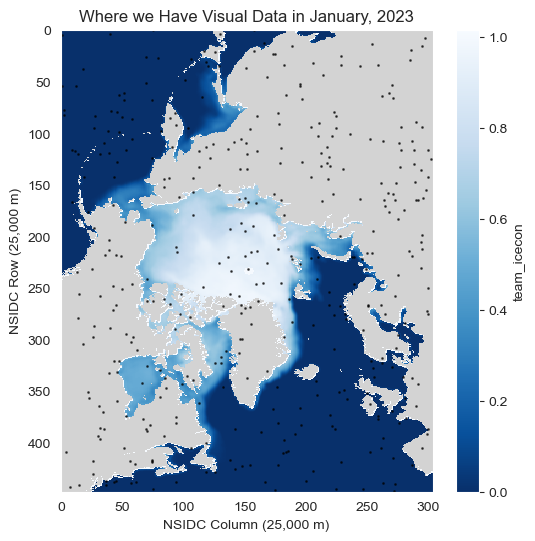

In [52]:
# sanity check two

ds_subset = ds.where(ds.edtl > 0)
ax = ds_subset.team_icecon.mean(dim='time').plot(
    cmap=cmap,
    figsize=(6,6)
)

plt.scatter(
    visual['col'],
    visual['row'],
    color='black',
    s=1,
    alpha=0.6
)
plt.title("Where we Have Visual Data in January, 2023")
plt.xlabel("NSIDC Column (25,000 m)")
plt.ylabel("NSIDC Row (25,000 m)")
plt.gca().invert_yaxis()
plt.show()

In [53]:
# error calculations

condition = ((ds.visual_ice.notnull()) & (ds.team_icecon < 1.001))
ds_clean = ds.where(condition, other=np.nan).compute()

# calc error

error_team = (((ds_clean['team_icecon'] - ds_clean['visual_ice'])**2)**0.5)
error_avg = error_team.mean(dim=['time', 'row', 'col'], skipna=True)
print('RMS error for NASA Team is', error_avg.compute().item())

RMS error for NASA Team is 0.0
